# Imports

In [1]:
import sys
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from reproject import reproject_interp

from minot.ClusterTools import map_tools
import pitszi

# Data and parameters

In [2]:
outdir = '/Users/adam/Desktop/NIKA_cluster_sample'
reso = 4*u.arcsec
FoV = 4*u.arcmin

In [3]:
# Cluster parameters
cls_name = ['RXJ1347', 'MACSJ1424', 'MACSJ0717', 'PSZ1G046', 'PSZ1G045', 'CLJ1227']
cls_redshift = [0.452, 0.545, 0.546, 0.569, 0.611, 0.888]
cls_M500 = [11.0, 4.9, 11.5, 6.4, 7.0, 5.7]
cls_coord = SkyCoord(['13:47:30.593 -11:45:10.05',  # ACCEPT
                      '14:23:47.759 +24:04:40.45',  # ACCEPT
                      '07:17:31.654 +37:45:18.52',  # ACCEPT
                      '17:17:05.800 +24:04:25.00',  # NIKA proposal
                      '15:18:20.800 +29:27:37.00',  # NIKA proposal
                      '12:26:58.373 +33:32:47.36'], # ACCEPT
                     frame='icrs', unit=(u.hourangle, u.deg))

# Instrument parameters
beam_FWHM = 18*u.arcsec
FoV_diameter = 2*u.arcmin
TF = []
for ic in cls_name:
    hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/TransferFunction150GHz_'+ic+'.fits')
    data_TF = hdul[1].data
    TF_i = data_TF['TF'][0]
    TF_i[np.isnan(TF_i)] = 1
    TF.append({'k':data_TF['WAVE_NUMBER_ARCSEC'][0]*u.arcsec**-1/2**0.5, 'TF':TF_i})

# Constants and usefull values
sigma2fwhm = 2 * np.sqrt(2*np.log(2))
y2jy = [-15e3, -11.6e3, -11.6e3, -11.6e3, -11.6e3, -11.6e3]

# Analysis parameters
mask_theta = 3*u.arcmin

(0.0, 1.1)

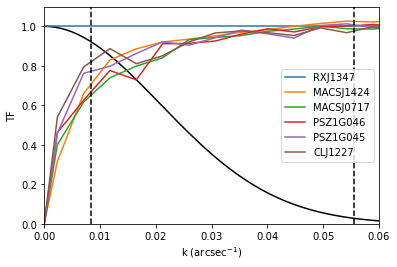

In [4]:
plt.plot(np.linspace(0, 1,1000), pitszi.utils_pk.beam_wf_pk(np.linspace(0, 1,1000), beam_FWHM.to_value('arcsec')), c='k')
for i in range(len(TF)): plt.plot(TF[i]['k'], TF[i]['TF'], label=cls_name[i])
plt.xlabel('k (arcsec$^{-1}$)')
plt.ylabel('TF')
plt.legend()
plt.axvline(1/beam_FWHM.to_value('arcsec'), c='k', ls='--')
plt.axvline(1/FoV_diameter.to_value('arcsec'), c='k', ls='--')
plt.xlim(0,0.06)
plt.ylim(0,1.1)

In [5]:
#===== Extract the data
cls_img = []
cls_ps = []
cls_head = []
cls_noise = []
cls_rms = []
for ic in range(len(cls_name)):  
    print('----- Cluster index:', ic+1)
    # Data image
    hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/MAP150GHz_'+cls_name[ic]+'.fits')
    new_header = map_tools.define_std_header(hdul[0].header['CRVAL1'], hdul[0].header['CRVAL2'],
                                             FoV.to_value('deg'), FoV.to_value('deg'), reso.to_value('deg'))
    img_ini  = hdul[0].data /y2jy[ic]
    img_ini, _ = reproject_interp((img_ini, hdul[0].header), new_header)
    cls_head.append(new_header)

    # Point source model
    hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/PointSourceModel150GHz_'+cls_name[ic]+'.fits')
    img_ps = hdul[0].data /y2jy[ic]
    img_ps, _ = reproject_interp((img_ps, hdul[0].header), new_header)
    cls_img.append(img_ini - img_ps)
    cls_ps.append(img_ps)
    
    # Noise
    hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/NoiseMC150GHz_'+cls_name[ic]+'.fits')
    noise = hdul[1].data/y2jy[ic]    
    noise =  np.swapaxes(np.swapaxes(noise, 2,0), 1,2)
    noise_rep = np.zeros((len(noise[:,0,0]), img_ini.shape[0], img_ini.shape[1]))
    for imc in range(len(noise[:,0,0])):
        repro, _ = reproject_interp((noise[imc,:,:], hdul[0].header), new_header)
        noise_rep[imc,:,:] = repro
    cls_noise.append(noise_rep)
    cls_rms.append(np.std(noise_rep, axis=0))

----- index: 0
----- index: 1
----- index: 2
----- index: 3
----- index: 4
----- index: 5


# Define the model, data and inference

In [6]:
cls_model = []
cls_data = []
cls_infer = []
for ic in range(len(cls_img)):
    #========== cluster model
    cluster = pitszi.Model(name=cls_name[ic], RA=cls_coord[ic].ra, Dec=cls_coord[ic].dec, 
                           redshift=cls_redshift[ic], M500=cls_M500[ic]*1e14*u.Msun, 
                           silent=True)

    cluster.set_pressure_profile_universal_param('A10UPP')

    cluster.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                          'Norm': 0.5, 
                                          'slope': -11/3.0,
                                          'Linj': 1*u.Mpc,
                                          'Ldis': 1*u.kpc}

    cluster.map_header = cls_head[ic]
    cluster.los_reso  = 50*u.kpc
    cluster.los_size  = 5*u.Mpc
    cluster.R_truncation = cluster.R500*5

    print('')
    print('----- Scale: '+cls_name[ic]+' -----')
    print('Pixel size in kpc: ', cluster.get_map_reso(physical=True))
    print('FoV in Mpc: ', cluster.get_map_fov(physical=True))
    
    cls_model.append(cluster)
    
    #========== cluster data
    data = pitszi.Data(cls_img[ic], cls_head[ic], silent=True)
    data.psf_fwhm              = beam_FWHM
    data.transfer_function     = TF[ic]

    #----- Define the mask
    ramap, decmap = map_tools.get_radec_map(data.header)
    dist_map = map_tools.greatcircle(ramap, decmap, data.header['CRVAL1'], data.header['CRVAL2'])
    mask = dist_map * 0 + 1
    mask[dist_map > mask_theta.to_value('deg')] = 0 
    data.mask = mask

    #----- Define the noise properties
    data.noise_mc = cls_noise[ic]
    data.set_noise_model_from_mc()
    data.noise_mc = data.get_noise_monte_carlo_from_model(Nmc=1000)
    data.noise_rms = data.get_noise_rms_from_model(Nmc=1000)

    cls_data.append(data)
    
    #========== Inference
    infer = pitszi.Inference(data, cluster, silent=True)
    infer.output_dir = outdir+'/'+cls_name[ic]
    
    infer.kbin_min   = 1/(3*u.arcmin)
    infer.kbin_max   = 1/(20*u.arcsec)
    infer.kbin_Nbin  = 10
    infer.kbin_scale = 'log'
    
    infer.method_use_covmat  = False
    infer.method_parallel    = False
    infer.method_data_deconv = False
    
    cls_infer.append(infer)


----- Scale: RXJ1347 -----
Pixel size in kpc:  23.79851323905828 kpc
FoV in Mpc:  [1451.70930758 1451.70930758] kpc

----- Scale: MACSJ1424 -----
Pixel size in kpc:  26.293137256264163 kpc
FoV in Mpc:  [1603.88137263 1603.88137263] kpc

----- Scale: MACSJ0717 -----
Pixel size in kpc:  26.317146668368224 kpc
FoV in Mpc:  [1605.34594677 1605.34594677] kpc

----- Scale: PSZ1G046 -----
Pixel size in kpc:  26.854200694701174 kpc
FoV in Mpc:  [1638.10624238 1638.10624238] kpc

----- Scale: PSZ1G045 -----
Pixel size in kpc:  27.76337349101625 kpc
FoV in Mpc:  [1693.56578295 1693.56578295] kpc

----- Scale: CLJ1227 -----
Pixel size in kpc:  31.92183472415166 kpc
FoV in Mpc:  [1947.23191817 1947.23191817] kpc


# Fit the smooth model to the data

In [7]:
for inf_i in cls_infer:
    print('---------- '+inf_i.model.name)
    RA = inf_i.model.coord.ra
    Dec = inf_i.model.coord.dec
    fitpar_prof = {
        #'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
        #'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
        #'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
        #'b': {'guess':[5, 0.5], 'unit': None, 'limit':[0, 10]},
        #'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[-1, 3]},
        'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10UPP'},
        #'min_to_maj_axis_ratio':{'guess':[1,0.1], 'unit':None, 'limit':[0,1]}, 
        #'angle':{'guess':[0,90], 'unit':u.deg, 'limit':[-90,90]},
        #'RA': {'guess':[RA.to_value('arcmin'), 0.5], 'unit': u.arcmin, 'limit':[RA.to_value('arcmin')-0.5, RA.to_value('arcmin')+0.5]},
        #'Dec': {'guess':[Dec.to_value('arcmin'), 0.5], 'unit': u.arcmin, 'limit':[Dec.to_value('arcmin')-0.5, Dec.to_value('arcmin')+0.5]},
        'ZL':{'guess':[0,1e-5],'unit':None},
                  }
    
    plist, popt, pcov = inf_i.run_curvefit_profile(fitpar_prof, 
                                                   show_fit_result=True, 
                                                   set_bestfit=True)

---------- RXJ1347
param 0 (M500): 
   median   = 27.173856268959547 -0.9779730577296419 +0.9585487585795569
   best-fit = 27.16701024878311 -0.971127037553206 +0.9653947787559929
   M500 = 27.173856268959547_{-0.9779730577296419}^{0.9585487585795569}
param 1 (ZL): 
   median   = -0.00014534593201421956 -1.39978578231047e-05 +1.3871222152256107e-05
   best-fit = -0.00014119031651802676 -1.8153473319297493e-05 +9.715606656063313e-06
   ZL = -0.00014534593201421956_{-1.39978578231047e-05}^{1.3871222152256107e-05}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- MACSJ1424
param 0 (M500): 
   median   = 12.892304280618067 -1.0900309250608498 +1.1232005333058765
   best-fit = 12.899772109243644 -1.097498753686427 +1.1157327046802994
   M500 = 12.892304280618067_{-1.0900309250608498}^{1.1232005333058765}
param 1 (ZL): 
   median   = 1.107521681100153e-05 -2.8945075422294795e-06 +2.9554351606510246e-06
   best-fit = 9.788951138565918e-06 -1.6082418697938675e-06 +4.241700833086637e-06
   ZL = 1.107521681100153e-05_{-2.8945075422294795e-06}^{2.9554351606510246e-06}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- MACSJ0717
param 0 (M500): 
   median   = 14.075411920616643 -0.3151622447246112 +0.31787263818439904
   best-fit = 14.077386615508523 -0.3171369396164909 +0.3158979432925193
   M500 = 14.075411920616643_{-0.3151622447246112}^{0.31787263818439904}
param 1 (ZL): 
   median   = 1.838486580164705e-05 -9.181200848452154e-07 +8.866379029397379e-07
   best-fit = 1.878968308085847e-05 -1.322937364056636e-06 +4.818206237283172e-07
   ZL = 1.838486580164705e-05_{-9.181200848452154e-07}^{8.866379029397379e-07}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- PSZ1G046
param 0 (M500): 
   median   = 7.515695038279118 -0.7637433517762755 +0.7596834540772655
   best-fit = 7.52083189808013 -0.7688802115772875 +0.7545465942762535
   M500 = 7.515695038279118_{-0.7637433517762755}^{0.7596834540772655}
param 1 (ZL): 
   median   = 1.0093560231242515e-05 -2.2579978164829485e-06 +2.236580156426433e-06
   best-fit = 1.1369030505570442e-05 -3.533468090810875e-06 +9.611098820985066e-07
   ZL = 1.0093560231242515e-05_{-2.2579978164829485e-06}^{2.236580156426433e-06}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- PSZ1G045
param 0 (M500): 
   median   = 8.50951679207268 -0.43555794834409767 +0.4513841996972925
   best-fit = 8.513055889463802 -0.43909704573521857 +0.4478451023061716
   M500 = 8.50951679207268_{-0.43555794834409767}^{0.4513841996972925}
param 1 (ZL): 
   median   = 1.080542355715815e-05 -1.5269079945209004e-06 +1.5210621482613699e-06
   best-fit = 1.2236002338601937e-05 -2.9574867759646876e-06 +9.04833668175827e-08
   ZL = 1.080542355715815e-05_{-1.5269079945209004e-06}^{1.5210621482613699e-06}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- CLJ1227
param 0 (M500): 
   median   = 8.362368580965816 -0.27686237576585526 +0.2773148065923383
   best-fit = 8.361083403468225 -0.2755771982682642 +0.27859998408992936
   M500 = 8.362368580965816_{-0.27686237576585526}^{0.2773148065923383}
param 1 (ZL): 
   median   = 1.4362130195240001e-05 -1.3771654919857604e-06 +1.4332858490133892e-06
   best-fit = 1.7546466278971296e-05 -4.5615015757170555e-06 +-1.751050234717906e-06
   ZL = 1.4362130195240001e-05_{-1.3771654919857604e-06}^{1.4332858490133892e-06}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


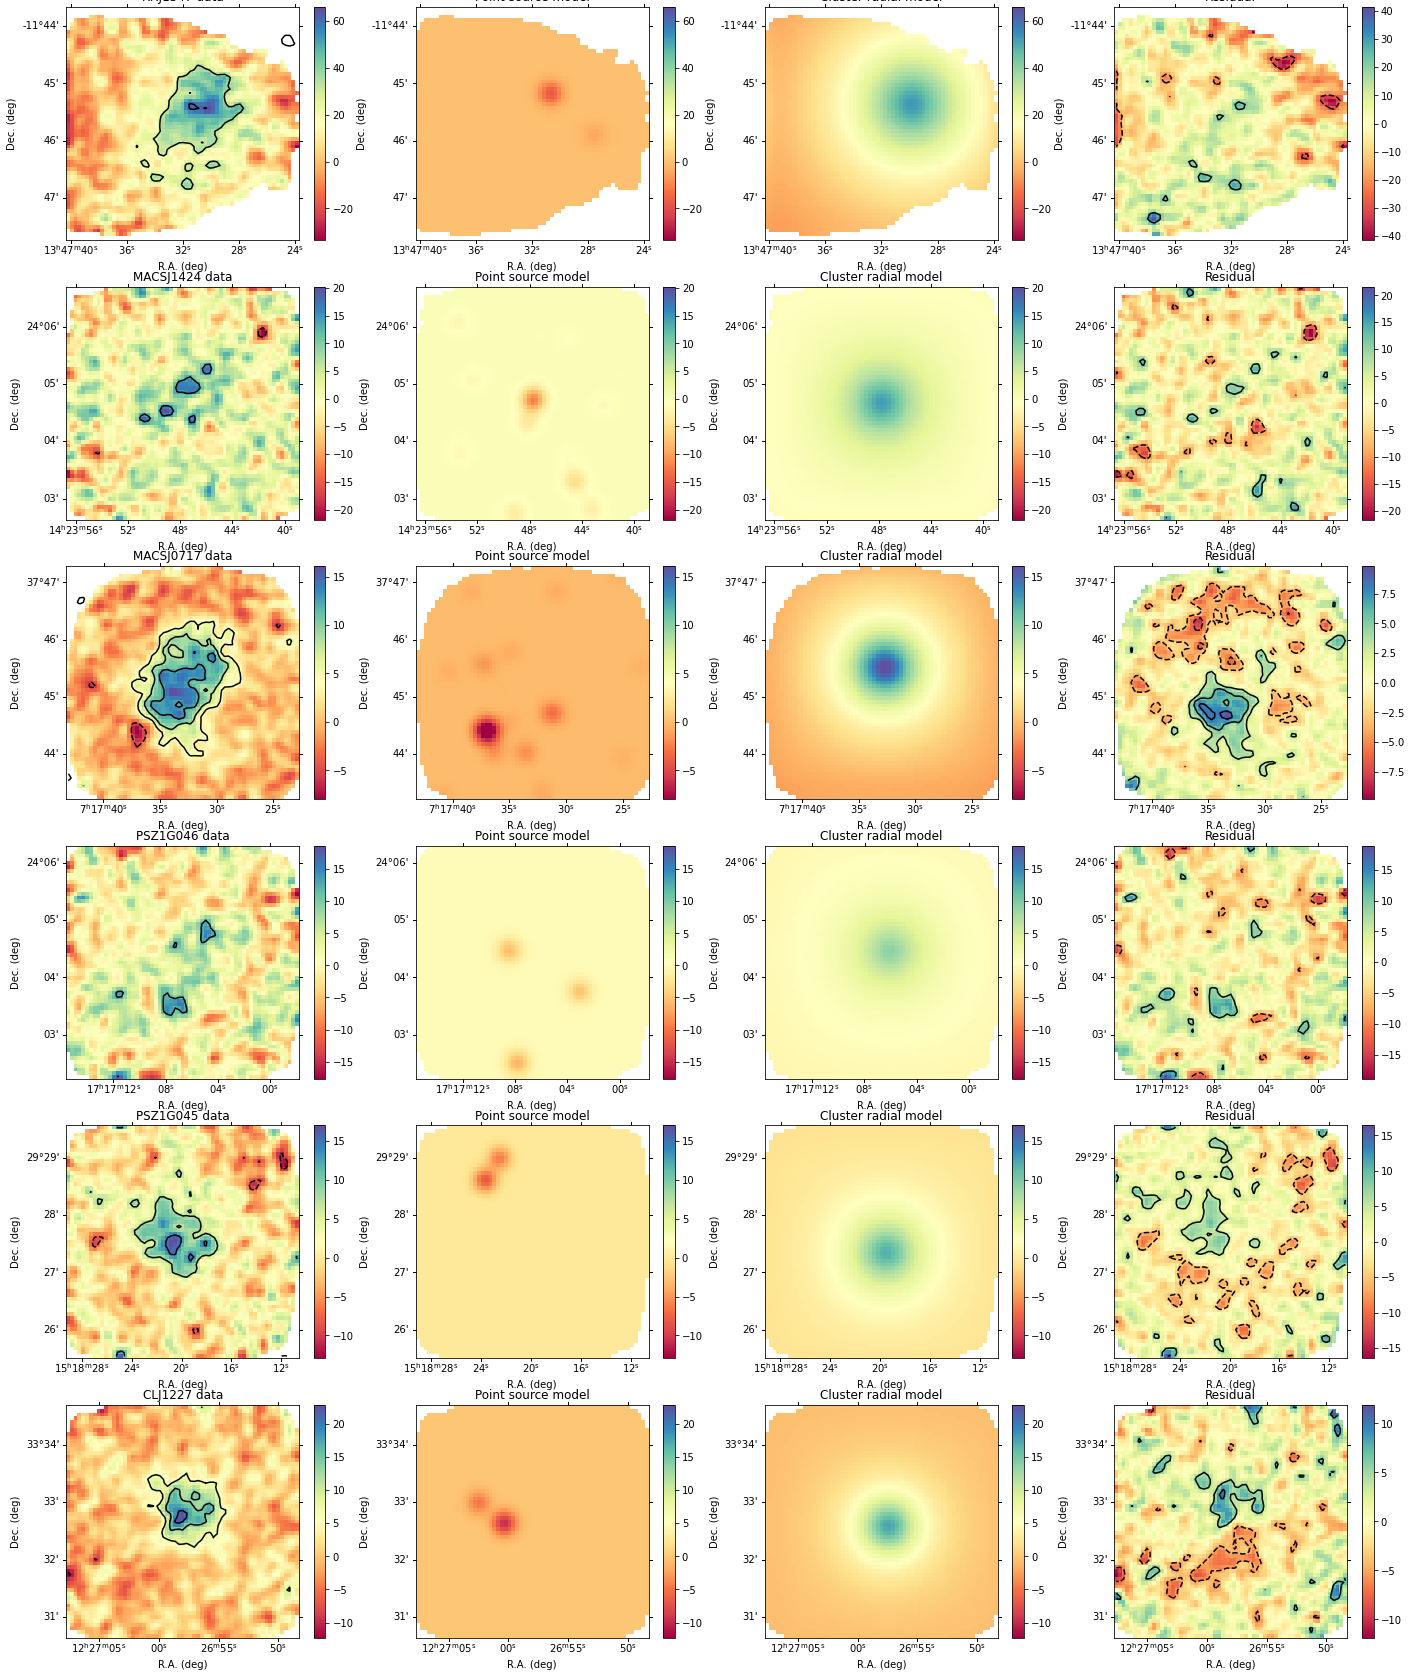

In [8]:
smooth_FWHM = 15*u.arcsec

# Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(24, 5*len(cls_img)))
for ic in range(len(cls_img)):
    model_sph = cls_infer[ic].get_radial_model()
    
    rms = cls_data[ic].get_noise_rms_from_model(Nmc=1000, smooth_fwhm=smooth_FWHM)
    rms = gaussian_filter(rms, sigma=10/3600/sigma2fwhm/cls_head[ic]['CDELT2'])
    
    mask = rms * 0 + 1
    mask[rms > 2*np.amin(rms)] = np.nan
    
    rng = [np.nanmin(mask*gaussian_filter(cls_img[ic]+cls_ps[ic], sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5),
           np.nanmax(mask*gaussian_filter(cls_img[ic]+cls_ps[ic], sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5)]
    
    #----- Image
    ax = plt.subplot(len(cls_img), 4, 4*ic+1, projection=WCS(cls_head[ic]))
    plt.imshow(mask*gaussian_filter(cls_img[ic]+cls_ps[ic], 
                                    sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5, 
               cmap='Spectral', vmin=rng[0], vmax=rng[1])
    cb = plt.colorbar()
    plt.contour(gaussian_filter(cls_img[ic]+cls_ps[ic], 
                                sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])
                /rms, levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
    plt.title(cls_name[ic]+' data')
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')
    
    #----- Point source model
    ax = plt.subplot(len(cls_img), 4, 4*ic+2, projection=WCS(cls_head[ic]))
    plt.imshow(mask*gaussian_filter(cls_ps[ic], 
                                    sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5, 
               cmap='Spectral', vmin=rng[0], vmax=rng[1])
    cb = plt.colorbar()
    plt.title('Point source model')
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')
    
    #----- Cluster model
    ax = plt.subplot(len(cls_img), 4, 4*ic+3, projection=WCS(cls_head[ic]))
    plt.imshow(mask*gaussian_filter(model_sph, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5, 
               cmap='Spectral', vmin=rng[0], vmax=rng[1])
    cb = plt.colorbar()
    plt.title('Cluster radial model')
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')
    
    #----- Residual
    rng = np.nanmax(mask*np.abs(gaussian_filter(cls_img[ic]-model_sph, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5))
    ax = plt.subplot(len(cls_img), 4, 4*ic+4, projection=WCS(cls_head[ic]))
    plt.imshow(mask*gaussian_filter(cls_img[ic]-model_sph, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5, 
               cmap='Spectral', vmin=-rng, vmax=rng)
    cb = plt.colorbar()
    plt.contour(mask*gaussian_filter(cls_img[ic]-model_sph, 
                                sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])
                /rms, levels=[-8,-6,-4,-2,2,4,6,8], colors='k')
    plt.title('Residual')
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')

# Extract the 3d power spectrum

In [9]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],      
    'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }
for inf_i in cls_infer:
    print('---------- '+inf_i.model.name)
    inf_i.silent = False
    inf_i.set_method_w8(apply_mask=True,
                        apply_radial_model=True, 
                        conv_radial_model_beam=True, 
                        conv_radial_model_TF=False, 
                        remove_GNFW_core=True, 
                        smooth_FWHM=20*u.arcsec)
    inf_i.setup()
    plist, popt, pcov = inf_i.run_curvefit_fluctuation(fitpar_pk3d, show_fit_result=True)

---------- RXJ1347
----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [  4.   4.   8.  16.  12.  32.  40.  72. 100. 180.]
      - Minimal count in k bins: 4.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing
----- The setup is done -----
param 0 (Norm): 
   median   = 0.7067820352923369 -0.25852016094254615 +0.2598097639668211
   best-fit = 0.9638837395651741 -0.5156218652153834 +0.0027080596939837998
   Norm = 0.7067820352923369_{-0.25852016094254615}^{0.2598097639668211}
param 1 (Linj): 
   median   = 1554.733998436742 -993.5507131913862 +979.29822399821
   best-fit = 2999.872687058741 -2438.6894018133853 +-465.8404646237891
   Linj = 1554.733998436742_{-993.5507131913862}^{979.29822399821}
param 2 (Anoise): 
   median   = 0.9647023639753478 -0.07510450893571297 +0.0756858773979423
   best-fit = 0.9757528407718348 -0.08615498573219993 +0.06463540060145534
   Anoise = 0.9647

KeyboardInterrupt: 